# Oregon's Congressional Apportionment as a Knapsack Optimization Model
<center>*Sabi Horvat, March 2021*</center>

To start, this notebook provides the context of US Congressional Apportionment and how the population of each state impacts the apportionment. However, for more details, please see the [Census.gov](https://www.census.gov/topics/public-sector/congressional-apportionment/about.html) definition and other sources. Using the example of Oregon, which is likely to receive a new Congressional District via the 2021 apportionment, the nonpartisan approach below is intended to be an aid for discussion that could be used in many scenarios.  As a nonpartisan approach, there will not be any data included from voter registration logs. In Oregon, the primary elections are closed, and therefore the voter registration includes political party affiliation.  

Instead, county population data, along with mathematical optimization, is used here to align districts through population constraints.  

The modeling approach is that of an assignment model, such as a supply chain example where Warehouses have a supply of products that they send to the customers that demand those products.  This particular assignment model has different constraints and objectives than most assignment models, and it is this unique complexity that makes the model interesting!  

## Model Objective and Constraints:

### Decision Variables

- $\text{assignment}_{i,j} \in [0,1]$: Whether the county [ i ] is assigned to the District [ j ]

- $\text{allocation}_{i,j} \in \mathbb{N}_{0}$: The non-negative amount of population from County [ i ] that is allocated to District [ j ]

### Objective Function

- **Assignments**: Minimize the number of counties assigned to districts

\begin{equation}
\text{Minimize} \quad Z = \sum_{(i,j) \in \text{Counties} \times \text{Districts}}{\text{assignment}_{i,j}}
\end{equation}

> Objective notes: In order to satisfy the constraints, all 36 counties must be assigned.  But counties can be assigned to multiple districts, increasing the upper bound of assignments to [36 counties]*[6 districts] = [216 assignments].  Minimizing the number of assignments while still meeting the constraints ensures that there will not be many counties that are split among multiple districts.  Requiring all counties to be assigned to only one district would make the model infeasible given the constraints to ensure the population of each district is close to equal.

### Constraints

- **Allocate all population**: Each county must have exactly all population allocated to districts.

\begin{equation}
\sum_{j \in \text{Districts}}{\text{assignment}_{i,j}} = \text{county_populations}_{i} \quad \forall i \in \text{Counties}
\end{equation}

- **Assignment required for Allocation**: Allocation can only be greater than zero if assignment is greater than zero. 

\begin{equation}
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \leq \text{M} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraint 1**: At least 20% of a county population must be allocated to a district if that county is assigned to that district.

\begin{equation}
\text{If }  {\text{assignment}_{i,j}} = \text{1 then }
\sum_{(i,j) \in \text{Counties} \times \text{Districts}} {\text{allocation}_{i,j}} \geq \text{0.20} \times {\text{county_population}_{i,j}} \times {\text{assignment}_{i,j}}
\end{equation}

- **Completeness Constraints 2 and 3**: All counties may be assigned to up to 1 district, but only counties with a population of at least 220,000 may be assigned to up to 2 districts. 

\begin{equation}
\text{If }  {\text{county_populations}_{i}} \leq \text{220,000 then }
\sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{1}
\quad \forall i \in \text{Counties}
\end{equation}

\begin{equation}
\text{Else } \sum_{j \in \text{Districts}} {\text{assignment}_{i,j}} \leq \text{2}
\end{equation}

- **Contiguous district constraints**: This constraint exists for each county.  For example, county [ 5 ],  Coos County (5) borders only Curry County (7) or Douglas County (8).  Therefore at least (7) or (8) need to be allocated to any district that has (5).

\begin{equation}
\text{assignment}_{5,j} \leq \text{assignment}_{7,j} + \text{assignment}_{9,j} \forall j \in \text{Districts}
\end{equation}

*Last Updated: 2021-03-15*

In [1]:
import geopandas as gpd # shapefile for Oregon county maps
import numpy as np  # data, np arrays are faster than lists
import pandas as pd # data
pd.set_option('display.max_rows', 50)

from PIL import Image, ImageOps # images
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, ggtitle, # plots
                       element_blank, element_rect, scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, LpStatus, value) # Linear Programming

## Oregon's population grew significantly since 2010
* Each of Oregon's five Congressional Districts had significant growth between 2010 and 2020
* Oregon's total population grew by about an estimated 9%, outpacing the US population's 6% growth
* *These numbers will be updated once the 2020 Census is completed and public*

In [2]:
district_populations = pd.DataFrame({'District': [1,2,3,4,5],
                                     'Population2010' : [775806,770403,782486,770184,772980],
                                     'Population2018' : [858875,841022,853116,820504,844220],
                                     'Change': [83069, 70619, 70630, 50320, 71240]})
district_populations = district_populations.style.format('{:,}')
district_populations

,District,Population2010,Population2018,Change
0,1,"775,806","858,875","83,069"
1,2,"770,403","841,022","70,619"
2,3,"782,486","853,116","70,630"
3,4,"770,184","820,504","50,320"
4,5,"772,980","844,220","71,240"


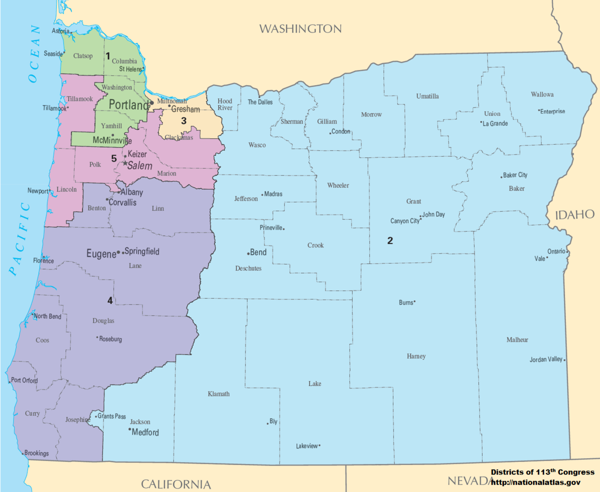

In [3]:
Image.open('Oregon_Congressional_Districts,_113th.png').resize((600, 492))

## Oregon is likely to gain a Congressional District from the 2020 Census
* The people of Oregon were already close to gaining their 6th Congressional District from the 2010 Census, according to the following infographic from the Pew Research Center.
* With the higher than average population growth rate, drawing the 6th District will have representative impact for the next decade and an incremental influence on presidential elections.

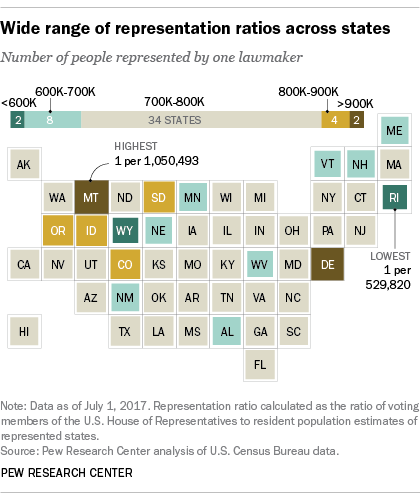

In [4]:
Image.open('FT_18.05.18_RepresentationRatios_states.png')

## Oregon's population varies greatly by its 36 counties

In [5]:
county_id = np.arange(0, 36)
county_names = np.array(['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill']) 
population_by_county = pd.DataFrame({'County_ID': county_id,
                                     'County_Name': county_names,
                                     'Population2018' : [16765,93590,419425,39200,51900,63275,22710,22915,188980,111735,1985,7400,7380,25310,219200,23560,86395,67960,8115,375120,48210,125575,31925,344035,11885,813300,82100,1785,26395,80765,26885,7175,27200,606280,1450,107415],
                                     'Population2010' : [16134,85579,375992,37039,49351,63043,20978,22364,157733,107667,1871,7445,7422,22346,203206,21720,82713,66380,7895,351715,46034,116672,31313,315335,11173,735334,75403,1765,25250,75889,25748,7008,25213,529710,1441,99193],
                                     'Change2010_2018': [631,8011,43433,2161,2549,232,1732,551,31247,4068,114,-45,-42,2964,15994,1840,3682,1580,220,23405,2176,8903,612,28700,712,77966,6697,20,1145,4876,1137,167,1987,76570,9,8222],
                                     'Latitude': [44.7346,44.4929,45.3088,46.1068,45.9189,43.175,44.1533,42.6002,43.9856,43.253,45.4204,44.5335,43.2214,45.6007,42.4441,44.4914,42.3351,42.5663,42.7821,44.0123,44.6733,44.4924,43.9454,44.9367,45.4757,45.5437,44.9262,45.4041,45.3957,45.726,45.3181,45.5356,45.3856,45.5404,44.7845,45.2256],
                                     'Longitude': [-117.6777,-123.3844,-122.3999,-123.8773,-122.9863,-124.179,-120.4523,-124.3343,-121.1699,-123.373,-120.2077,-119.0668,-119.0481,-121.7147,-122.7875,-121.3246,-123.5119,-121.6302,-120.4691,-123.1668,-123.9267,-122.7806,-117.484,-122.7301,-119.6694,-122.5346,-123.3237,-120.7307,-123.8622,-118.745,-117.9619,-117.2036,-121.2283,-123.002,-120.02,-123.1982]})

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

shapefile_oregon = gpd.read_file('orcounty.shp')
map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
county_populations = np.array(population_by_county['Population2018'])
state_population = sum(county_populations)
population_by_county.sort_values('Population2018', ascending = False)

,County_ID,County_Name,Population2018,Population2010,Change2010_2018,Latitude,Longitude
25,25,Multnomah,813300,735334,77966,45.5437,-122.5346
33,33,Washington,606280,529710,76570,45.5404,-123.0020
2,2,Clackamas,419425,375992,43433,45.3088,-122.3999
19,19,Lane,375120,351715,23405,44.0123,-123.1668
23,23,Marion,344035,315335,28700,44.9367,-122.7301
14,14,Jackson,219200,203206,15994,42.4441,-122.7875
8,8,Deschutes,188980,157733,31247,43.9856,-121.1699
21,21,Linn,125575,116672,8903,44.4924,-122.7806
9,9,Douglas,111735,107667,4068,43.2530,-123.3730
35,35,Yamhill,107415,99193,8222,45.2256,-123.1982


## The Willamette River valley contributes to ~70% of the state population

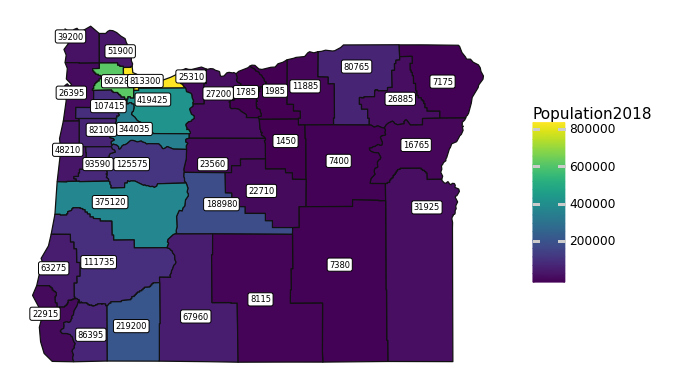

<ggplot: (8793537015790)>

In [6]:
map_population_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Population2018'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2018',size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank()
       )
)
map_population_by_county

## Population growth from 2010 to 2018 (estimated) occurred in the most populous counties.

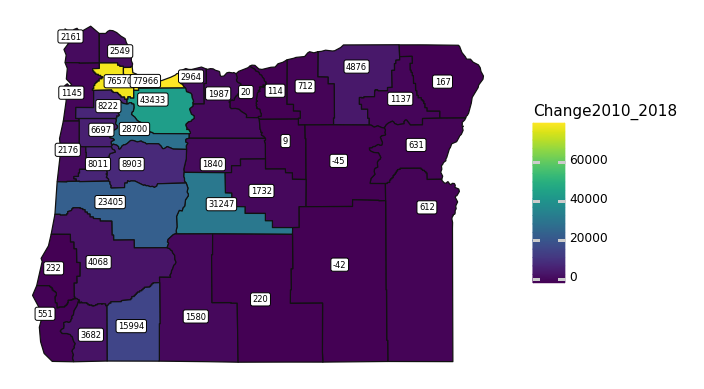

<ggplot: (8793537127882)>

In [7]:
map_population_change_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Change2010_2018'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Change2010_2018', size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank(),
        panel_grid_minor = element_blank()
       )
)
map_population_change_by_county

# Optimization Model

The first step in this modeling process is to run the following optimization model.  After running the initial model, additional constraints will be added to hone in on the solution.  In practice, an algorithm can be written to create such additional constraints.  The next steps will show why such an algorithm is necessary.

In [8]:
n_counties = 36
n_districts = 6

model = LpProblem("Supply-Demand-Problem", LpMinimize) # create model
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) for i in range(1, n_counties+1)]
variable_names.sort() # print("Variable Indices:", variable_names)

# decision variables
# assignment is whether or not the county is assigned to the district
DV_variable_y = LpVariable.matrix("Y",variable_names,cat="Binary")
assignment = np.array(DV_variable_y).reshape(36,6)

# allocation is the amount of population from a county to a district
DV_variable_x = LpVariable.matrix("X",variable_names,cat="Integer",lowBound=0)#upBound N/A
allocation = np.array(DV_variable_x).reshape(36,6)    

In [9]:
# This objective function minimizes the counties are split among multiple districts.
objective_function = lpSum(assignment) 

In [10]:
# Initial Assignment / Allocation Constraints

# allocate exactly 100% of population from each county 
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

for i in range(n_counties): 
    for j in range(n_districts):
        # allocation can only be greater than zero if assignment is greater than zero
        # sum(county_populations) is a big M, which is the Oregon total population
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] , "Allocation assignment " + str(i) + str(j)
        if assignment[i][j] == 1:
            # at least 20% of population must be allocated to each district for that county
            model += allocation[i][j] >= assignment[i][j]*0.20*county_populations[i] , "Allocation min " + str(i) + str(j)

# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
for j in range(n_districts):
    model += assignment[0][j] <= assignment[11][j]+assignment[22][j]+assignment[30][j]+assignment[31][j]  
    model += assignment[1][j] <= assignment[19][j]+assignment[20][j]+assignment[21][j]+assignment[26][j] 
    model += assignment[2][j] <= assignment[13][j]+assignment[23][j]+assignment[25][j]+assignment[32][j]+assignment[33][j]+assignment[35][j]
    model += assignment[3][j] <= assignment[4][j]+assignment[28][j] 
    model += assignment[4][j] <= assignment[3][j]+assignment[25][j]+assignment[33][j]
    model += assignment[5][j] <= assignment[7][j]+assignment[9][j] 
    model += assignment[6][j] <= assignment[8][j]+assignment[11][j]+assignment[12][j]+assignment[15][j]+assignment[34][j]
    model += assignment[7][j] <= assignment[5][j]+assignment[9][j]+assignment[16][j] 
    model += assignment[8][j] <= assignment[6][j]+assignment[12][j]+assignment[15][j]+assignment[17][j]+assignment[18][j]+assignment[19][j]+assignment[21][j]
    model += assignment[9][j] <= assignment[5][j]+assignment[7][j]+assignment[14][j]+assignment[16][j]+assignment[17][j]+assignment[19][j]
    model += assignment[10][j] <= assignment[24][j]+assignment[27][j]+assignment[32][j]+assignment[34][j]
    model += assignment[11][j] <= assignment[0][j]+assignment[6][j]+assignment[12][j]+assignment[22][j]+assignment[24][j]+assignment[29][j]+assignment[30][j]+assignment[34][j]
    model += assignment[12][j] <= assignment[6][j]+assignment[8][j]+assignment[11][j]+assignment[18][j]+assignment[22][j]
    model += assignment[13][j] <= assignment[2][j]+assignment[25][j]+assignment[32][j]
    model += assignment[14][j] <= assignment[9][j]+assignment[16][j]+assignment[17][j]
    model += assignment[15][j] <= assignment[6][j]+assignment[8][j]+assignment[21][j]+assignment[23][j]+assignment[32][j]+assignment[34][j]
    model += assignment[16][j] <= assignment[7][j]+assignment[9][j]+assignment[14][j]
    model += assignment[17][j] <= assignment[8][j]+assignment[9][j]+assignment[14][j]+assignment[18][j]+assignment[19][j]
    model += assignment[18][j] <= assignment[8][j]+assignment[12][j]+assignment[17][j]
    model += assignment[19][j] <= assignment[1][j]+assignment[8][j]+assignment[9][j]+assignment[17][j]+assignment[20][j]+assignment[21][j]
    model += assignment[20][j] <= assignment[1][j]+assignment[19][j]+assignment[26][j]+assignment[28][j]
    model += assignment[21][j] <= assignment[1][j]+assignment[8][j]+assignment[15][j]+assignment[19][j]+assignment[23][j]+assignment[26][j] 
    model += assignment[22][j] <= assignment[0][j]+assignment[11][j]+assignment[12][j]
    model += assignment[23][j] <= assignment[2][j]+assignment[15][j]+assignment[21][j]+assignment[26][j]+assignment[32][j]+assignment[35][j]
    model += assignment[24][j] <= assignment[10][j]+assignment[11][j]+assignment[29][j]+assignment[34][j]
    model += assignment[25][j] <= assignment[2][j]+assignment[4][j]+assignment[13][j]+assignment[33][j]
    model += assignment[26][j] <= assignment[1][j]+assignment[20][j]+assignment[21][j]+assignment[23][j]+assignment[28][j]+assignment[35][j]
    model += assignment[27][j] <= assignment[10][j]+assignment[32][j]
    model += assignment[28][j] <= assignment[3][j]+assignment[20][j]+assignment[26][j]+assignment[33][j]+assignment[35][j]
    model += assignment[29][j] <= assignment[11][j]+assignment[24][j]+assignment[30][j]+assignment[31][j]
    model += assignment[30][j] <= assignment[0][j]+assignment[11][j]+assignment[29][j]+assignment[31][j]
    model += assignment[31][j] <= assignment[0][j]+assignment[29][j]+assignment[30][j]
    model += assignment[32][j] <= assignment[2][j]+assignment[10][j]+assignment[13][j]+assignment[15][j]+assignment[23][j]+assignment[27][j]+assignment[34][j]
    model += assignment[33][j] <= assignment[2][j]+assignment[4][j]+assignment[25][j]+assignment[28][j]+assignment[35][j]
    model += assignment[34][j] <= assignment[6][j]+assignment[10][j]+assignment[11][j]+assignment[15][j]+assignment[24][j]+assignment[32][j]
    model += assignment[35][j] <= assignment[2][j]+assignment[23][j]+assignment[26][j]+assignment[28][j]+assignment[33][j]
    
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= 750000 , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= 650000 , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 220,000 to be split among up to two districts
for i in range(n_counties): # added
    if county_populations[i] <= 220000: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments " + str(i)

In [11]:
model.solve(PULP_CBC_CMD()) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

The model status is:  Optimal
The objective value is:  40.0


Since there are 36 counties, the lower bound for the objective function is 36.  However, an objective value of 40 means that there are 4 occasions that a county was assigned to two districts.

### Results (first pass)
The map below will show why more constraints will be added to the model below.  Although the constraints have been satisfied, districts have multiple clusters that are not connected to each other.  The constraints to eliminate multiple clusters for a district are sometimes referred to as [Cut constraints](https://en.wikipedia.org/wiki/Cutting-plane_method) in Operations Research.

In [12]:
# create dataframe with pulp results
results = []
for j in range(n_districts):
    #district_totals = lpSum(round(allocation[i][j].value()) for i in range(n_counties))
    #print("District", str(j+1), "Population: " , f"{value(district_totals):,.0f}", "\n")
    for i in range(n_counties):
        var_output = {
            'County ID' : i,
            'County Name': county_names[i],
            'District': j+1,
            #'Allocation': f"{value(allocation[i][j].value()):,.0f}"
            'Allocation': allocation[i][j].value()
        }
        results.append(var_output)
results_df = pd.DataFrame.from_records(results)
results_df = results_df[results_df.Allocation > 0] # .set_index('County')
results_df_by_district = results_df[results_df.Allocation > 0] # .set_index('County')
results_df['Allocation'] = results_df['Allocation'].astype('int64').apply('{:,}'.format)

In [13]:
# Counties in Multiple Districts
results_df[results_df.duplicated(subset=['County Name'],keep=False)].sort_values('County Name')

,County ID,County Name,District,Allocation
74,2,Clackamas,3,"181,425"
182,2,Clackamas,6,"238,000"
127,19,Lane,4,"75,024"
163,19,Lane,5,"300,096"
95,23,Marion,3,"228,995"
131,23,Marion,4,"115,040"
61,25,Multnomah,2,"624,690"
133,25,Multnomah,4,"188,610"


In [14]:
# data preparation for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*(j+1)}
        result_value.append(var_output)
        
assignment_results = pd.DataFrame(result_value)
assignment_results = assignment_results[assignment_results['Assignment'] > 0]
assignment_results.sort_values(['County', 'District'])
assignment_results = assignment_results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))

In [15]:
color_dict = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral'}
map_first_pass = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
map_first_pass['District'] = map_first_pass['District']+1
map_first_pass_labels = map_first_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
map_first_pass_labels['District'] = map_first_pass_labels['District'].astype('category')
map_first_pass_labels['Assignment'] = map_first_pass_labels['Assignment'].astype("category")

In [16]:
def oregon_map(map_data, colors):
    plot_map = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) # geom_map(aes(fill='District'))
    + geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2018', size = 2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major = element_blank(),
            panel_grid_minor = element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values = colors))
    return plot_map

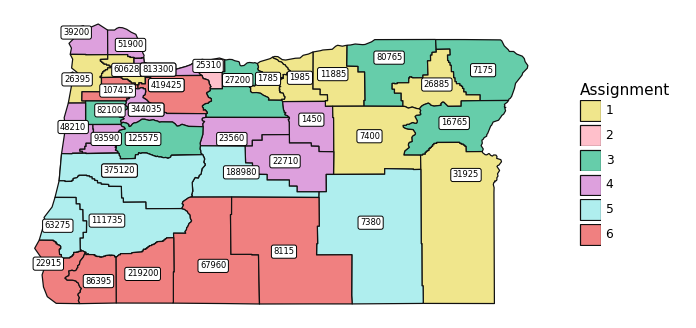

<ggplot: (8793537094388)>

In [17]:
oregon_map(map_first_pass_labels, color_dict)

## Add more constraints and re-run the model
The results satisfy the current constraints, but there can always be improvements by adding more constraints.  Particularly, a better result would have each district in only one contiguous cluster.  To promote such a result in the model, the following improvement constraints prevent certain counties from being in the same district.  The constraints below prevent counties that have significant population centers in between them from being assigned to the same district.

Additionally, this map colors each county per a district assignment, but four counties are assigned to multiple districts.

In [18]:
# Improvement Assignment / Allocation Constraints (sometimes known as cuts)

# pairs of counties that are far apart geographically with population centers in between them
for j in range(n_districts):
    # Baker (0) on the east not to be assigned to the west beyond population centers in the middle
    model += assignment[0][j] + assignment[1][j] <= 1 
    model += assignment[0][j] + assignment[3][j] <= 1 
    model += assignment[0][j] + assignment[4][j] <= 1 
    model += assignment[0][j] + assignment[5][j] <= 1 
    model += assignment[0][j] + assignment[6][j] <= 1 
    model += assignment[0][j] + assignment[19][j] <= 1 
    model += assignment[0][j] + assignment[20][j] <= 1 
    model += assignment[0][j] + assignment[21][j] <= 1 
    model += assignment[0][j] + assignment[23][j] <= 1 
    model += assignment[0][j] + assignment[25][j] <= 1 
    model += assignment[0][j] + assignment[26][j] <= 1 
    model += assignment[0][j] + assignment[28][j] <= 1 
    model += assignment[0][j] + assignment[33][j] <= 1 
    model += assignment[0][j] + assignment[35][j] <= 1 
    # same with Grant (11)
    model += assignment[11][j] + assignment[1][j] <= 1 
    model += assignment[11][j] + assignment[3][j] <= 1 
    model += assignment[11][j] + assignment[4][j] <= 1 
    model += assignment[11][j] + assignment[5][j] <= 1 
    model += assignment[11][j] + assignment[6][j] <= 1 
    model += assignment[11][j] + assignment[19][j] <= 1
    model += assignment[11][j] + assignment[20][j] <= 1
    model += assignment[11][j] + assignment[21][j] <= 1
    model += assignment[11][j] + assignment[23][j] <= 1
    model += assignment[11][j] + assignment[25][j] <= 1
    model += assignment[11][j] + assignment[26][j] <= 1
    model += assignment[11][j] + assignment[28][j] <= 1
    model += assignment[11][j] + assignment[33][j] <= 1
    model += assignment[11][j] + assignment[35][j] <= 1
    # same with Harney (12)
    model += assignment[12][j] + assignment[1][j] <= 1 
    model += assignment[12][j] + assignment[3][j] <= 1 
    model += assignment[12][j] + assignment[4][j] <= 1 
    model += assignment[12][j] + assignment[5][j] <= 1 
    model += assignment[12][j] + assignment[6][j] <= 1 
    model += assignment[12][j] + assignment[19][j] <= 1
    model += assignment[12][j] + assignment[20][j] <= 1
    model += assignment[12][j] + assignment[21][j] <= 1
    model += assignment[12][j] + assignment[23][j] <= 1
    model += assignment[12][j] + assignment[25][j] <= 1
    model += assignment[12][j] + assignment[26][j] <= 1
    model += assignment[12][j] + assignment[28][j] <= 1
    model += assignment[12][j] + assignment[33][j] <= 1
    model += assignment[12][j] + assignment[35][j] <= 1
    # same with Malheur (22)
    model += assignment[22][j] + assignment[1][j] <= 1 
    model += assignment[22][j] + assignment[3][j] <= 1 
    model += assignment[22][j] + assignment[4][j] <= 1 
    model += assignment[22][j] + assignment[5][j] <= 1 
    model += assignment[22][j] + assignment[6][j] <= 1 
    model += assignment[22][j] + assignment[19][j] <= 1
    model += assignment[22][j] + assignment[20][j] <= 1
    model += assignment[22][j] + assignment[21][j] <= 1
    model += assignment[22][j] + assignment[23][j] <= 1
    model += assignment[22][j] + assignment[25][j] <= 1
    model += assignment[22][j] + assignment[26][j] <= 1
    model += assignment[22][j] + assignment[28][j] <= 1
    model += assignment[22][j] + assignment[33][j] <= 1
    model += assignment[22][j] + assignment[35][j] <= 1
    # same with Morrow (24)
    model += assignment[24][j] + assignment[1][j] <= 1 
    model += assignment[24][j] + assignment[3][j] <= 1 
    model += assignment[24][j] + assignment[4][j] <= 1 
    model += assignment[24][j] + assignment[5][j] <= 1 
    model += assignment[24][j] + assignment[6][j] <= 1 
    model += assignment[24][j] + assignment[19][j] <= 1
    model += assignment[24][j] + assignment[20][j] <= 1
    model += assignment[24][j] + assignment[21][j] <= 1
    model += assignment[24][j] + assignment[23][j] <= 1
    model += assignment[24][j] + assignment[25][j] <= 1
    model += assignment[24][j] + assignment[26][j] <= 1
    model += assignment[24][j] + assignment[28][j] <= 1
    model += assignment[24][j] + assignment[33][j] <= 1
    model += assignment[24][j] + assignment[35][j] <= 1
    # same with Umatilla (29)
    model += assignment[29][j] + assignment[1][j] <= 1 
    model += assignment[29][j] + assignment[3][j] <= 1 
    model += assignment[29][j] + assignment[4][j] <= 1 
    model += assignment[29][j] + assignment[5][j] <= 1 
    model += assignment[29][j] + assignment[6][j] <= 1 
    model += assignment[29][j] + assignment[19][j] <= 1
    model += assignment[29][j] + assignment[20][j] <= 1
    model += assignment[29][j] + assignment[21][j] <= 1
    model += assignment[29][j] + assignment[23][j] <= 1
    model += assignment[29][j] + assignment[25][j] <= 1
    model += assignment[29][j] + assignment[26][j] <= 1
    model += assignment[29][j] + assignment[28][j] <= 1
    model += assignment[29][j] + assignment[33][j] <= 1
    model += assignment[29][j] + assignment[35][j] <= 1
    # same with Union (30)
    model += assignment[30][j] + assignment[1][j] <= 1 
    model += assignment[30][j] + assignment[3][j] <= 1 
    model += assignment[30][j] + assignment[4][j] <= 1 
    model += assignment[30][j] + assignment[5][j] <= 1 
    model += assignment[30][j] + assignment[6][j] <= 1 
    model += assignment[30][j] + assignment[19][j] <= 1
    model += assignment[30][j] + assignment[20][j] <= 1
    model += assignment[30][j] + assignment[21][j] <= 1
    model += assignment[30][j] + assignment[23][j] <= 1
    model += assignment[30][j] + assignment[25][j] <= 1
    model += assignment[30][j] + assignment[26][j] <= 1
    model += assignment[30][j] + assignment[28][j] <= 1
    model += assignment[30][j] + assignment[33][j] <= 1
    model += assignment[30][j] + assignment[35][j] <= 1
    # same with Wallowa (31)
    model += assignment[31][j] + assignment[1][j] <= 1 
    model += assignment[31][j] + assignment[3][j] <= 1 
    model += assignment[31][j] + assignment[4][j] <= 1 
    model += assignment[31][j] + assignment[5][j] <= 1 
    model += assignment[31][j] + assignment[6][j] <= 1 
    model += assignment[31][j] + assignment[19][j] <= 1 
    model += assignment[31][j] + assignment[20][j] <= 1 
    model += assignment[31][j] + assignment[21][j] <= 1 
    model += assignment[31][j] + assignment[23][j] <= 1 
    model += assignment[31][j] + assignment[25][j] <= 1 
    model += assignment[31][j] + assignment[26][j] <= 1 
    model += assignment[31][j] + assignment[28][j] <= 1 
    model += assignment[31][j] + assignment[33][j] <= 1 
    model += assignment[31][j] + assignment[35][j] <= 1 
    # southwest counties (5,6,9,19) shouldn't be in the same district as north counties
    # Coos County (5)
    model += assignment[5][j] + assignment[3][j] <= 1
    model += assignment[5][j] + assignment[4][j] <= 1
    model += assignment[5][j] + assignment[6][j] <= 1
    model += assignment[5][j] + assignment[10][j] <= 1
    model += assignment[5][j] + assignment[11][j] <= 1
    model += assignment[5][j] + assignment[15][j] <= 1
    model += assignment[5][j] + assignment[24][j] <= 1
    model += assignment[5][j] + assignment[27][j] <= 1
    model += assignment[5][j] + assignment[28][j] <= 1
    model += assignment[5][j] + assignment[34][j] <= 1
    # Curry County (7)
    model += assignment[7][j] + assignment[3][j] <= 1
    model += assignment[7][j] + assignment[4][j] <= 1
    model += assignment[7][j] + assignment[6][j] <= 1
    model += assignment[7][j] + assignment[10][j] <= 1
    model += assignment[7][j] + assignment[11][j] <= 1
    model += assignment[7][j] + assignment[15][j] <= 1
    model += assignment[7][j] + assignment[24][j] <= 1
    model += assignment[7][j] + assignment[27][j] <= 1
    model += assignment[7][j] + assignment[28][j] <= 1
    model += assignment[7][j] + assignment[34][j] <= 1
    # Douglas County (9)
    model += assignment[9][j] + assignment[3][j] <= 1
    model += assignment[9][j] + assignment[4][j] <= 1
    model += assignment[9][j] + assignment[6][j] <= 1
    model += assignment[6][j] + assignment[10][j] <= 1
    model += assignment[9][j] + assignment[11][j] <= 1
    model += assignment[9][j] + assignment[15][j] <= 1
    model += assignment[9][j] + assignment[24][j] <= 1
    model += assignment[9][j] + assignment[27][j] <= 1
    model += assignment[9][j] + assignment[28][j] <= 1
    model += assignment[9][j] + assignment[34][j] <= 1
    # Lane County (19)
    model += assignment[19][j] + assignment[3][j] <= 1
    model += assignment[19][j] + assignment[4][j] <= 1
    model += assignment[19][j] + assignment[6][j] <= 1
    model += assignment[19][j] + assignment[10][j] <= 1
    model += assignment[19][j] + assignment[11][j] <= 1
    model += assignment[19][j] + assignment[15][j] <= 1
    model += assignment[19][j] + assignment[24][j] <= 1
    model += assignment[19][j] + assignment[27][j] <= 1
    model += assignment[19][j] + assignment[28][j] <= 1
    model += assignment[19][j] + assignment[34][j] <= 1
    # northwest counties (3,4,28) shouldn't be in the same district as counties on other side of population centers
    model += assignment[3][j] + assignment[1][j] <= 1
    model += assignment[3][j] + assignment[6][j] <= 1
    model += assignment[3][j] + assignment[8][j] <= 1
    model += assignment[3][j] + assignment[10][j] <= 1
    model += assignment[3][j] + assignment[21][j] <= 1
    model += assignment[3][j] + assignment[27][j] <= 1
    model += assignment[4][j] + assignment[1][j] <= 1
    model += assignment[4][j] + assignment[6][j] <= 1
    model += assignment[4][j] + assignment[8][j] <= 1
    model += assignment[4][j] + assignment[10][j] <= 1
    model += assignment[4][j] + assignment[21][j] <= 1
    model += assignment[4][j] + assignment[27][j] <= 1
    model += assignment[28][j] + assignment[1][j] <= 1
    model += assignment[28][j] + assignment[6][j] <= 1
    model += assignment[28][j] + assignment[8][j] <= 1
    model += assignment[28][j] + assignment[10][j] <= 1
    model += assignment[28][j] + assignment[21][j] <= 1
    model += assignment[28][j] + assignment[27][j] <= 1
    # multnomah
    model += assignment[6][j] + assignment[25][j] <= 1 
    model += assignment[7][j] + assignment[25][j] <= 1 
    model += assignment[10][j] + assignment[25][j] <= 1
    model += assignment[16][j] + assignment[25][j] <= 1
    model += assignment[17][j] + assignment[25][j] <= 1
    model += assignment[18][j] + assignment[25][j] <= 1
    model += assignment[19][j] + assignment[25][j] <= 1
    model += assignment[20][j] + assignment[25][j] <= 1
    model += assignment[21][j] + assignment[25][j] <= 1
    model += assignment[23][j] + assignment[25][j] <= 1
    model += assignment[26][j] + assignment[25][j] <= 1
    model += assignment[27][j] + assignment[25][j] <= 1
    model += assignment[28][j] + assignment[25][j] <= 1
    model += assignment[34][j] + assignment[25][j] <= 1
    # these constraints from practice iterations
    model += assignment[3][j] + assignment[32][j] <= 1 
    model += assignment[3][j] + assignment[34][j] <= 1 
    model += assignment[4][j] + assignment[22][j] <= 1 
    model += assignment[4][j] + assignment[32][j] <= 1 
    model += assignment[4][j] + assignment[34][j] <= 1 
    model += assignment[7][j] + assignment[33][j] <= 1 
    model += assignment[8][j] + assignment[26][j] <= 1 
    model += assignment[8][j] + assignment[28][j] <= 1 
    model += assignment[8][j] + assignment[33][j] <= 1 
    model += assignment[9][j] + assignment[28][j] <= 1 
    model += assignment[9][j] + assignment[33][j] <= 1 
    model += assignment[10][j] + assignment[28][j] <= 1
    model += assignment[14][j] + assignment[28][j] <= 1 
    model += assignment[14][j] + assignment[33][j] <= 1 
    model += assignment[16][j] + assignment[33][j] <= 1 
    model += assignment[17][j] + assignment[33][j] <= 1 
    model += assignment[18][j] + assignment[28][j] <= 1 
    model += assignment[18][j] + assignment[33][j] <= 1 
    model += assignment[24][j] + assignment[28][j] <= 1 
    model += assignment[28][j] + assignment[29][j] <= 1 


In [19]:
model.solve(PULP_CBC_CMD()) 
print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

The model status is:  Optimal
The objective value is:  40.0


The model still assigns four counties to multiple districts.  But the solution is different, as we'll see below.

In [20]:
# data preparation for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {'County': i,'District': j,'Assignment': int(assignment[i][j].value()*(j+1))}
        result_value.append(var_output)
        
assignment_results = pd.DataFrame(result_value)
assignment_results = assignment_results[assignment_results['Assignment'] != 0]
assignment_results = assignment_results.sort_values(['County','District'])
assignment_results = assignment_results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))
assignment_results['Multiple_County_Name'] = assignment_results['County_Name'].shift(periods=1)
assignment_results['Multiple_District'] = assignment_results['District'].shift(periods=1).fillna(99).astype(int)

In [21]:
# Editing the assignment variable to capture when a county is assigned to multiple districts
for i in range(0,len(assignment_results)):
    if assignment_results['County_Name'].loc[i] == assignment_results['Multiple_County_Name'].loc[i]:
        assignment_results['Assignment'].loc[i] =   int(str(assignment_results['District'].loc[i]+1) + \
                                                     str(assignment_results['Multiple_District'].loc[i]+1))
assignment_results = assignment_results.sort_values(['District','County_Name'])

/Users/alberta/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
map_second_pass = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
map_second_pass['District'] = map_second_pass['District']+1
map_second_pass_labels = map_second_pass.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))
map_second_pass_labels['District'] = map_second_pass_labels['District'].astype('category')
map_second_pass_labels['Assignment'] = map_second_pass_labels['Assignment'].astype('category')

In [23]:
# Adding grey as the color for counties assigned to multiple districts in the 2nd pass results
color_dict2 = { 1 : 'khaki',
               2 : 'pink',
               3 : 'mediumaquamarine',
               4 : 'plum',
               5 : 'paleturquoise',
               6 : 'lightcoral',
               31 : 'grey',
               61 : 'grey',
               62 : 'grey',
               63 : 'grey'}

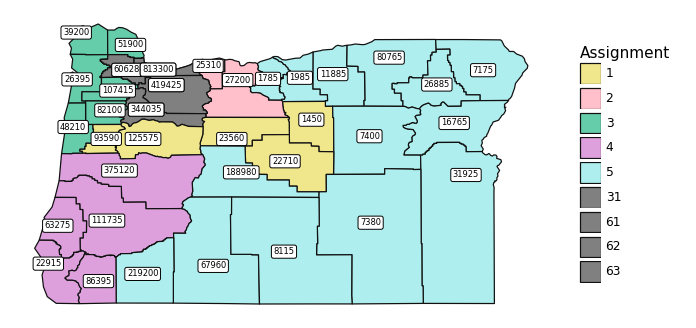

<ggplot: (8793537549996)>

In [24]:
oregon_map(map_second_pass_labels, color_dict2)

## Results 
Colored in grey are Clackamas, Multnomah, Washington, and Marion counties. These counties are assigned to multiple districts. The results in these populous counties would need to be inspected further for Congressional Apportionment, but this model shows that a solution is possible.

Adding more improvement constraints can still improve the solution.  Doing so or using different random seeds may also provide alternative solutions.  Scroll down to see the full results of the solution table.

In [25]:
# Verify that all population was assigned
print('State Population: ', f"{state_population:,.0f}")
print('Assigned Population: ', f"{value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):,.0f}", '\n')
if state_population == value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):
    print('All population was assigned to districts')
else:
    print('All population was not assigned to districts, investigate why this may have happened')

State Population:  4,195,300
Assigned Population:  4,195,300 

All population was assigned to districts


In [26]:
# create dataframe with pulp results
results = []
for j in range(n_districts):
    for i in range(n_counties):
        var_output = {
            'County ID' : i,
            'County Name': county_names[i],
            'District': j+1,
            'Allocation': allocation[i][j].value()
        }
        results.append(var_output)
results_df = pd.DataFrame.from_records(results)
results_df = results_df[results_df.Allocation > 0] 
results_df_by_district = results_df[results_df.Allocation > 0] 
results_df['Allocation'] = results_df['Allocation'].astype('int64').apply('{:,}'.format)
results_df = results_df.set_index('County ID')

In [27]:
# Total Population by District
district_totals = pd.DataFrame(results_df_by_district.groupby('District')['Allocation'].sum().astype('int64').apply('{:,}'.format))
district_totals

,Allocation
District,
1,"750,000"
2,"703,150"
3,"750,000"
4,"659,440"
5,"678,205"
6,"654,505"


In [28]:
# Counties in Multiple Districts
results_df[results_df.duplicated(subset=['County Name'],keep=False)].sort_values('County Name')

,County Name,District,Allocation
County ID,,,
2,Clackamas,1,"335,540"
2,Clackamas,6,"83,885"
23,Marion,1,"147,575"
23,Marion,3,"196,460"
25,Multnomah,2,"650,640"
25,Multnomah,6,"162,660"
33,Washington,3,"198,320"
33,Washington,6,"407,960"


## Results by District

In [29]:
results_df[results_df.District==1]

,County Name,District,Allocation
County ID,,,
1,Benton,1,"93,590"
2,Clackamas,1,"335,540"
6,Crook,1,"22,710"
15,Jefferson,1,"23,560"
21,Linn,1,"125,575"
23,Marion,1,"147,575"
34,Wheeler,1,"1,450"


In [30]:
results_df[results_df.District==2]

,County Name,District,Allocation
County ID,,,
13,Hood River,2,"25,310"
25,Multnomah,2,"650,640"
32,Wasco,2,"27,200"


In [31]:
results_df[results_df.District==3]

,County Name,District,Allocation
County ID,,,
3,Clatsop,3,"39,200"
4,Columbia,3,"51,900"
20,Lincoln,3,"48,210"
23,Marion,3,"196,460"
26,Polk,3,"82,100"
28,Tillamook,3,"26,395"
33,Washington,3,"198,320"
35,Yamhill,3,"107,415"


In [32]:
results_df[results_df.District==4]

,County Name,District,Allocation
County ID,,,
5,Coos,4,"63,275"
7,Curry,4,"22,915"
9,Douglas,4,"111,735"
16,Josephine,4,"86,395"
19,Lane,4,"375,120"


In [33]:
results_df[results_df.District==5]

,County Name,District,Allocation
County ID,,,
0,Baker,5,"16,765"
8,Deschutes,5,"188,980"
10,Gilliam,5,"1,985"
11,Grant,5,"7,400"
12,Harney,5,"7,380"
14,Jackson,5,"219,200"
17,Klamath,5,"67,960"
18,Lake,5,"8,115"
22,Malheur,5,"31,925"


In [34]:
results_df[results_df.District==6]

,County Name,District,Allocation
County ID,,,
2,Clackamas,6,"83,885"
25,Multnomah,6,"162,660"
33,Washington,6,"407,960"
